In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pypsa

from plotting_constants import nice_names, color_dict

In [2]:
day = '2024-03-21'

In [3]:
sc = pd.read_csv(Path.cwd().parent / 'results' / f'{day}' /  'system_cost_summary_flex.csv', index_col=[0,1], parse_dates=[0])

In [4]:
if day != 'total':
    fn_nat = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(day, 'national')
    fn_zonal = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(day, 'zonal')
else:
    fn_nat = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv').format('national')
    fn_zonal = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv').format('zonal')

In [5]:
nat = pd.read_csv(
    fn_nat,
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)
zon = pd.read_csv(
    fn_zonal,
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

In [6]:
bids = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv', index_col=[0,1])
offers = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'offers.csv', index_col=[0,1])

In [7]:
def process_balancing_data(df):
    df = (
        df
        .stack()
        .unstack(1)
        .dropna()
        .groupby(level=1)
        .agg({'price': 'mean', 'vol': 'sum'})
        .sort_values('price')
    )
    return df


def get_weighted_avg_price(df):
    assert set(df.columns) == {'price', 'vol'}, 'Columns must be price and vol'
    assert not df.empty, 'DataFrame must not be empty'

    return (df['price'] * df['vol']).sum() / df['vol'].sum()


In [8]:
backup = pd.read_csv(
    Path.cwd().parent / 'data' / 'prerun' / 'balancing_prices' / '2024-week12.csv', index_col=0
)

In [9]:
if not bids.empty:
    bid_price = get_weighted_avg_price(process_balancing_data(bids))
else:
    bid_price = backup.loc['bids', 'disp']

if not offers.empty:
    offer_price = get_weighted_avg_price(process_balancing_data(offers))
else:
    offer_price = backup.loc['offers', 'disp']

In [10]:
nat_who = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)
nat_bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved_redispatch.nc'
)
zon_who = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_zonal_solved.nc'
)
zon_bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_zonal_solved_redispatch.nc'
)

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved_redispatch.nc has buses, carriers, generators, links, loads


In [ ]:
zon_who.buses_t.marginal_price.iloc[20].value_counts()

2024-03-21 10:00:00
 80.659588    225
-58.070776     59
 58.286743      2
 54.268445      1
 40.971220      1
 56.684565      1
Name: count, dtype: int64

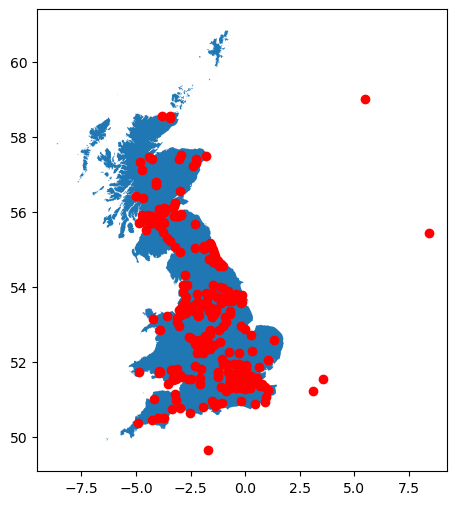

In [12]:
import geopandas as gpd

gb = gpd.read_file(Path.cwd().parent / 'data' / 'GB_shape.geojson').set_index('name')

gdf = gpd.GeoDataFrame(
        zon_who.buses,
        geometry=gpd.points_from_xy(
            zon_who.buses['x'], zon_who.buses['y']
            )
        ).set_crs('EPSG:4326')
    
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gb.plot(ax=ax)
gdf.plot(ax=ax, color='r')

plt.show()

mask = gdf.within(gb.loc['GB', 'geometry'])
gb_buses = zon_who.buses.index[mask]

In [13]:
zon_who.buses_t.marginal_price.loc[:,gb_buses].iloc[10].value_counts()

2024-03-21 05:00:00
 61.060775    225
-58.070776     59
Name: count, dtype: int64

In [14]:
zon_who.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country
Bus,,,,,,,,,,,,,
8838,380.0,,-2.169800,53.243852,AC,,1.0,0.0,inf,PQ,,,GB
8013,380.0,,-2.270050,57.410941,AC,,1.0,0.0,inf,PQ,,,GB
8649,380.0,,-1.724854,52.571342,AC,,1.0,0.0,inf,PQ,,,GB
4950,380.0,,0.303497,52.288323,AC,,1.0,0.0,inf,PQ,,,GB
4951,380.0,,0.045319,51.928178,AC,,1.0,0.0,inf,PQ,,,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,380.0,,3.560000,51.530000,electricity,,1.0,0.0,inf,PQ,,,Netherlands
France,380.0,,-1.710000,49.640000,electricity,,1.0,0.0,inf,PQ,,,France
Belgium,380.0,,3.120000,51.230000,electricity,,1.0,0.0,inf,PQ,,,Belgium


In [15]:
roc = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'roc_values.csv', index_col=0)

cfd = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'cfd_strike_prices.csv', index_col=0)
cfd.columns = pd.to_datetime(cfd.columns)
cfd = cfd.loc[:,:day].iloc[:,-1]

In [16]:
def get_unit_revenues(unit, who, bal):
    """
    Calculate revenue timeseries for a generation unit from multiple sources.
    
    Parameters:
    - unit: Generator name/ID
    - who: Wholesale market model network
    - bal: Balancing market model network
    
    Returns:
    - DataFrame with timeseries of revenue components
    """
    # Time step in hours (half-hourly)
    dt = 0.5

    # Initialize dataframe with snapshots as index
    snapshots = who.snapshots
    revenues = pd.DataFrame(index=snapshots, columns=[
        'wholesale', 'roc', 'cfd', 'ftr', 'offer_cost', 'bid_cost'
    ], data=0.0)

    if unit in who.links.index:
        dispatch = who.links_t.p0[unit]
        price0 = who.buses_t.marginal_price[who.links.loc[unit, 'bus0']]
        price1 = who.buses_t.marginal_price[who.links.loc[unit, 'bus1']]

        price_diff = abs(price0 - price1)
        revenues['wholesale'] = dispatch * price_diff * dt

        # revenues['total'] = revenues.sum(axis=1)

        return revenues
    

    if unit in who.storage_units.index:
        # Get storage unit dispatch
        who_dispatch = who.storage_units_t.p_dispatch[unit] - who.storage_units_t.p_store[unit]
        who_prices = who.buses_t.marginal_price[who.storage_units.loc[unit, 'bus']]
        revenues['wholesale'] = who_dispatch * who_prices * dt
        
        # Add ROC revenue if applicable
        if unit in roc.index:
            roc_value = roc.loc[unit, 'roc_value']
            revenues['roc'] = who_dispatch * roc_value * dt
            
        # revenues['total'] = revenues.sum(axis=1)
        return revenues

    # 1. Wholesale market revenue
    who_dispatch = who.generators_t.p[unit] if unit in who.generators_t.p else pd.Series(0, index=snapshots)
    who_prices = who.buses_t.marginal_price[who.generators.loc[unit, 'bus']]
    revenues['wholesale'] = who_dispatch * who_prices * dt

    bal_dispatch = bal.generators_t.p[unit] if unit in bal.generators_t.p else pd.Series(0, index=snapshots)

    # 2. ROC revenue (if applicable)
    if unit in roc.index:
        roc_value = roc.loc[unit, 'roc_value']
        revenues['roc'] = bal_dispatch * roc_value * dt

    # 3. CfD revenue (if applicable)
    if 'cfd' in globals() and unit in cfd.index:
        strike_price = cfd.loc[unit]
        
        # Check for negative price periods (at least 6 hours)
        negative_price_periods = who_prices < 0
        # Create a rolling window of 12 periods (6 hours with half-hourly data)
        rolling_negative = negative_price_periods.rolling(window=12).sum()
        # Identify snapshots where we shouldn't pay topup (preceded by 6+ hours of negative prices)
        no_topup_periods = rolling_negative >= 12
        
        # Calculate CfD top-up only for eligible periods
        topup_rates = strike_price - who_prices
        # Set topup to zero for periods following 6+ hours of negative prices
        topup_rates[no_topup_periods] = 0
        
        revenues['cfd'] = topup_rates * bal_dispatch * dt
    
    # 4. FTR revenue
    if len(who.buses) >= 20:
        # Get the unit's bus
        unit_bus = who.generators.loc[unit, 'bus']
        
        # For each timestep, check if there are exactly two unique prices
        for snapshot in snapshots:
            # Get unique prices across all buses for this snapshot
            unique_prices = who.buses_t.marginal_price.loc[:, gb_buses].loc[snapshot].unique()
            
            high_price = max(unique_prices)
            
            unit_price = who.buses_t.marginal_price.loc[snapshot, unit_bus]
            price_diff = abs(high_price - unit_price)
            
            # If unit is in the lower price zone, it gets FTR revenue
            revenues.loc[snapshot, 'ftr'] = who_dispatch[snapshot] * price_diff * dt
    
    # 5. Balancing revenue (if dispatch differs between models)
    if unit in bal.generators_t.p and unit in who.generators_t.p:
        dispatch_diff = bal.generators_t.p[unit] - who.generators_t.p[unit]
        bal_prices = bal.buses_t.marginal_price[bal.generators.loc[unit, 'bus']]
        
        # Calculate separately for up and down balancing
        up_balancing = dispatch_diff.clip(lower=0)
        down_balancing = dispatch_diff.clip(upper=0)
        
        # Balancing offers (turning up)
        up_revenue = up_balancing * bal_prices * dt
        
        # Apply ROC and CfD adjustments for turning up
        if unit in roc.index:
            roc_value = roc.loc[unit, 'roc_value']
            # For turning up, they would pay their ROC value
            up_revenue -= up_balancing * roc_value * dt
        
        elif unit in cfd.index:
            strike_price = cfd.loc[unit]
            # For turning up, they would pay their topup
            topup_rates = strike_price - who_prices
            up_revenue -= up_balancing * topup_rates * dt
        
        else:
            up_revenue = up_balancing * offer_price * dt

        revenues['offer_cost'] = up_revenue

        # Apply ROC and CfD adjustments for turning down
        if unit in roc.index:
            roc_value = roc.loc[unit, 'roc_value']
            # For turning down, they receive their ROC value per MWh curtailed
            down_revenue = down_balancing.abs() * roc_value * dt  # Negative * negative = positive

        elif unit in cfd.index:
            strike_price = cfd.loc[unit]
            # For turning down, they are forgoing their topup, so they get paid for that
            topup_rates = strike_price - who_prices
            down_revenue = down_balancing.abs() * topup_rates * dt  # Negative * positive = negative
        
        else:
            down_revenue = down_balancing.abs() * offer_price * dt

        revenues['bid_cost'] = down_revenue
    
    # revenues['total'] = revenues.sum(axis=1)

    return revenues


In [17]:
all_units = nat_who.generators.index[nat_who.generators.carrier != 'local_market'].union(
    nat_who.storage_units.index.union(
        nat_who.links.index[nat_who.links.carrier == 'interconnector']
    )
)

all_carriers = pd.concat((
    nat_who.generators.loc[nat_who.generators.carrier != 'local_market', 'carrier'],
    nat_who.storage_units['carrier'],
    nat_who.links.loc[nat_who.links.carrier == 'interconnector', 'carrier']
)) 

all_carriers

CMSTW-1             onwind
ROTHW-1             onwind
PAUHW-1             onwind
CAIRW-2             onwind
MDHLW-1             onwind
                 ...      
IFA2        interconnector
Nemo        interconnector
Viking      interconnector
ElecLink    interconnector
NSL         interconnector
Name: carrier, Length: 417, dtype: object

In [18]:
from tqdm import tqdm

all_revenues = list()

for unit in tqdm(all_units):

    n = get_unit_revenues(unit, nat_who, nat_bal)
    z = get_unit_revenues(unit, zon_who, zon_bal)

    # Concatenate the DataFrames with a new 0th index layer
    n.columns = pd.MultiIndex.from_product([[unit], ['national'], n.columns])
    z.columns = pd.MultiIndex.from_product([[unit], ['zonal'], z.columns])

    all_revenues.extend([n, z])

all_revenues = pd.concat(all_revenues, axis=1)

100%|██████████| 417/417 [00:15<00:00, 27.32it/s]


In [19]:
lv3_carriers = ['onwind', 'offwind', 'nuclear', 'hydro', 'cascade']

In [20]:
idx = pd.IndexSlice

available_shares = pd.Series(np.nan, all_carriers.unique())

for carrier in lv3_carriers:

    print(carrier)

    national_total = all_revenues.sum().loc[idx[all_carriers.loc[all_carriers == carrier].index, 'national']].sum()
    zonal_total = all_revenues.sum().loc[idx[all_carriers.loc[all_carriers == carrier].index, 'zonal']].sum()
    available_shares.loc[carrier] = zonal_total / national_total


onwind
offwind
nuclear
hydro
cascade


In [21]:
available_shares

onwind            0.934516
offwind           0.808049
solar                  NaN
nuclear           0.983164
fossil                 NaN
biomass                NaN
battery                NaN
PHS                    NaN
cascade           0.158304
hydro             0.052058
interconnector         NaN
dtype: float64

In [22]:
hold = all_revenues.copy()

for carrier, share in available_shares.dropna().items():

    print(carrier)

    units = all_carriers.index[all_carriers == carrier]
    ss = hold.loc[:, idx[units, 'national']].T.groupby(level=0).sum().T * share

    ss.columns = pd.MultiIndex.from_product([ss.columns, ['equitable'], ['level3']])

    hold = pd.concat((
        hold, ss
    ), axis=1)


hold = hold.sort_index(axis=1)

onwind
offwind
nuclear
cascade
hydro


<Axes: xlabel='snapshot'>

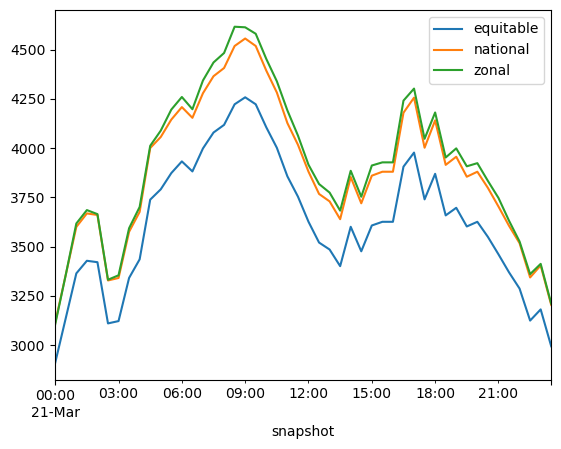

In [23]:
hold.loc[:,idx['CMSTW-1']].T.groupby(level=0).sum().T.plot()

In [24]:
syscosts = pd.read_csv(Path.cwd().parent / 'results' / f'{day}' / 'system_cost_summary_flex.csv', index_col=[0,1], parse_dates=[0])
sc = syscosts.loc[syscosts.index.get_level_values(1) != 'balancing_volume']

ss1 = sc['zonal'].unstack()
ss2 = sc['national'].unstack()

ss1 *= 1e3
ss2 *= 1e3

ss1['settlement_period'] = range(1, len(ss1) + 1)
ss2['settlement_period'] = range(1, len(ss2) + 1)

json_result = {
    "dataName": 'System Costs',
    "data": [
        {
            key1: {'zonal': value1, 'national': value2} for (key1, value1), (key2, value2) in zip(row1.items(), row2.items())
        }
        for (_, row1), (_, row2) in zip(ss1.iterrows(), ss2.iterrows())
    ]
}

import json

with open(f'system_costs.json', 'w') as f:
    json.dump(json_result, f, indent=2)

In [25]:
import numpy as np
import pandas as pd

# Create a dummy DataFrame with MultiIndex for policy analysis
# This will be used to store and analyze different policy scenarios

# Define the levels for our MultiIndex
policies = ['baseline', 'fixed_price', 'cap_and_floor', 'two_sided_cfd']
technologies = ['wind', 'solar', 'nuclear', 'gas', 'storage']
metrics = ['revenue', 'volatility', 'cost_to_consumer', 'market_distortion']

# Create MultiIndex
index = pd.MultiIndex.from_product([policies, technologies], 
                                   names=['policy', 'technology'])

# Create columns MultiIndex
columns = pd.MultiIndex.from_product([['annual', 'monthly', 'daily'], metrics],
                                     names=['timeframe', 'metric'])

# Create the dummy DataFrame with random values
np.random.seed(42)  # For reproducibility
dummy_data = np.random.rand(len(index), len(columns)) * 100
dummy_df = pd.DataFrame(data=dummy_data, index=index, columns=columns)

# Add some realistic patterns to the data
# Higher volatility for renewables in baseline
volatility_cols = [(t, 'volatility') for t in ['annual', 'monthly', 'daily']]
for t in ['wind', 'solar']:
    dummy_df.loc[('baseline', t), volatility_cols] *= 2
    
# Lower volatility but higher cost for fixed price
for t in technologies:
    dummy_df.loc[('fixed_price', t), [(tf, 'volatility') for tf in ['annual', 'monthly', 'daily']]] *= 0.3
    dummy_df.loc[('fixed_price', t), [(tf, 'cost_to_consumer') for tf in ['annual', 'monthly', 'daily']]] *= 1.5

# Display the first few rows of the dummy DataFrame
dummy_df.head()


timeframe               annual                                                 \
metric                 revenue  volatility cost_to_consumer market_distortion   
policy   technology                                                             
baseline wind        37.454012  190.142861        73.199394         59.865848   
         solar       83.244264   42.467822        18.182497         18.340451   
         nuclear     45.606998   78.517596        19.967378         51.423444   
         gas         30.461377    9.767211        68.423303         44.015249   
         storage     54.671028   18.485446        96.958463         77.513282   

timeframe              monthly                                                 \
metric                 revenue  volatility cost_to_consumer market_distortion   
policy   technology                                                             
baseline wind        15.601864   31.198904         5.808361         86.617615   
         solar       30.424224  104.951286        43.194502         29.122914   
         nuclear     59.241457    4.645041        60.754485         17.052412   
         gas         12.203823   49.517691         3.438852         90.932040   
         storage     93.949894   89.482735        59.789998         92.187424   

timeframe                daily                                                 
metric                 revenue  volatility cost_to_consumer market_distortion  
policy   technology                                                            
baseline wind        60.111501  141.614516         2.058449         96.990985  
         solar       61.185289   27.898772        29.214465         36.636184  
         nuclear      6.505159   94.888554        96.563203         80.839735  
         gas         25.877998   66.252228        31.171108         52.006802  
         storage      8.849250   19.598286         4.522729         32.533033

In [26]:
idx = pd.IndexSlice

policy_mapper = {
    'lev1': idx['annual', ['revenue', 'volatility']],
}

dummy_df.loc[:, policy_mapper['lev1']]

timeframe                    annual            
metric                      revenue  volatility
policy        technology                       
baseline      wind        37.454012  190.142861
              solar       83.244264   42.467822
              nuclear     45.606998   78.517596
              gas         30.461377    9.767211
              storage     54.671028   18.485446
fixed_price   wind        38.867729    8.140471
              solar        0.552212   24.463843
              nuclear     31.098232    9.755500
              gas         52.273283   12.826231
              storage     22.879817    2.309397
cap_and_floor wind        80.744016   89.609130
              solar       11.986537   33.761517
              nuclear     28.484049    3.688695
              gas         67.213555   76.161962
              storage      4.077514   59.089294
two_sided_cfd wind        34.106635   11.347352
              solar       90.041806   63.310146
              nuclear     60.642906    0.919705
              gas         32.539970   74.649141
              storage     89.204656   63.113863

In [27]:
print(nat_who.generators.loc[nat_who.generators.carrier == 'nuclear'].index)

Index(['HEYM27', 'HEYM28', 'HRTL-1', 'SIZB-1', 'SIZB-2', 'TORN-1', 'TORN-2'], dtype='object', name='Generator')


In [28]:
# get_unit_revenues('GORDW-1, nat_who, nat_bal).head()
get_unit_revenues('SIZB-2', zon_who, zon_bal).head()

,wholesale,roc,cfd,ftr,offer_cost,bid_cost
snapshot,,,,,,
2024-03-21 00:00:00,22482.946168,0.0,0.0,0.000000,0.0,0.0
2024-03-21 00:30:00,21966.615000,0.0,0.0,0.000000,0.0,0.0
2024-03-21 01:00:00,21665.071163,0.0,0.0,0.000000,0.0,0.0
2024-03-21 01:30:00,19953.868820,0.0,0.0,0.000000,0.0,0.0
2024-03-21 02:00:00,18371.039495,0.0,0.0,15.175011,0.0,0.0


In [29]:
print(nat_who.generators.loc[nat_who.generators.carrier == 'fossil'].index[:5])
ss = nat_who.generators.loc[nat_who.generators.carrier == 'fossil'].index

random_choice = np.random.choice(ss)
# get_unit_revenues(random_choice, nat_who, nat_bal)

Index(['BRGDG-1', 'AG-NHAV02', 'ABERU-1', 'BRGG-1', 'BRIDU-1'], dtype='object', name='Generator')


In [30]:
# Get offshore wind generators from both networks
offshore_wind_who = nat_who.generators[nat_who.generators.carrier.isin(['onwind', 'offwind'])]
offshore_wind_bal = nat_bal.generators[nat_bal.generators.carrier.isin(['onwind', 'offwind'])]

# Get the dispatch for each generator in both networks
who_dispatch = {}
bal_dispatch = {}
deviations = {}

for gen in offshore_wind_who.index:
    if gen in nat_who.generators_t.p.columns:
        who_dispatch[gen] = nat_who.generators_t.p[gen].sum() * 0.5

for gen in offshore_wind_bal.index:
    if gen in nat_bal.generators_t.p.columns:
        bal_dispatch[gen] = nat_bal.generators_t.p[gen].sum() * 0.5

# Calculate deviations between the two models
for gen in who_dispatch:
    if gen in bal_dispatch:
        deviations[gen] = abs(who_dispatch[gen] - bal_dispatch[gen])

# Get the bus coordinates for each generator
gen_bus_info = {}
for gen in deviations:
    bus_id = nat_bal.generators.loc[gen, 'bus']
    y_coord = nat_bal.buses.loc[bus_id, 'y']
    gen_bus_info[gen] = {
        'bus': bus_id,
        'latitude': y_coord,
        'deviation': deviations[gen]
    }

# Group generators by bus
bus_generators = {}
for gen, info in gen_bus_info.items():
    bus_id = info['bus']
    if bus_id not in bus_generators:
        bus_generators[bus_id] = []
    bus_generators[bus_id].append(gen)

# Sort buses by latitude (descending)
sorted_buses = sorted(bus_generators.keys(), 
                     key=lambda bus: nat_bal.buses.loc[bus, 'y'],
                     reverse=True)


# Print results by bus, sorted by latitude
print("Offshore wind generator dispatch deviations by bus (sorted by latitude):")
print("-" * 100)
print(f"{'Bus':<10} {'Latitude':<12} {'Generator':<15} {'Deviation (MWh)':<15} {'Support Type':<16}")
print("-" * 100)


dispatched_roc_units = []
curtailed_roc_units = []
dispatched_cfd_units = []
curtailed_cfd_units = []

for bus in sorted_buses:
    bus_lat = nat_bal.buses.loc[bus, 'y']
    for i, gen in enumerate(bus_generators[bus]):
        # Determine support type
        if 'roc' in globals() and gen in roc.index:
            support_type = "ROC"
        elif 'cfd' in globals() and gen in cfd.index:
            support_type = "CfD"
        else:
            support_type = "None"
        
        if support_type == "ROC":
            if deviations[gen] == 0:
                dispatched_roc_units.append(gen)
            else:
                curtailed_roc_units.append(gen)
        elif support_type == "CfD":
            if deviations[gen] == 0:
                dispatched_cfd_units.append(gen)
            else:
                curtailed_cfd_units.append(gen)

        if i == 0:
            # Print bus info only for the first generator of each bus
            print(f"{bus:<10} {bus_lat:<12.6f} {gen:<15} {deviations[gen]:<15.2f} {support_type:<16}")
        else:
            # For other generators of the same bus, don't repeat bus info
            print(f"{'':<10} {'':<12} {gen:<15} {deviations[gen]:<15.2f} {support_type:<16}")
    print("-" * 100)

Offshore wind generator dispatch deviations by bus (sorted by latitude):
----------------------------------------------------------------------------------------------------
Bus        Latitude     Generator       Deviation (MWh) Support Type    
----------------------------------------------------------------------------------------------------
6441       58.546761    ABRTW-1         501.00          ROC             
                        GORDW-1         0.00            ROC             
                        GORDW-2         748.20          ROC             
                        KILBW-1         0.00            ROC             
                        STRNW-1         725.06          ROC             
----------------------------------------------------------------------------------------------------
6443       58.490823    CMSTW-1         0.00            ROC             
                        BNWKW-1         0.00            ROC             
                        HALSW-1         

In [31]:
# these hold for 21.03.2024
dispatched_roc_unit = 'GORDW-1'
dispatched_cfd_unit = 'WLNYO-4'
curtailed_cfd_unit = 'DOREW-1'
curtailed_roc_unit = 'SGRWO-1'

In [32]:
sc.loc[~sc.index.get_level_values(1).isin(['balancing_volume', 'congestion_rent'])].sum()

nodal       71.820094
zonal       69.839690
national    87.016601
dtype: float64

In [33]:
from tqdm import tqdm

roc_rev_nat = pd.Series(0, index=nat_who.snapshots)
roc_rev_zon = pd.Series(0, index=zon_who.snapshots)

for bus in tqdm(sorted_buses):
    bus_lat = nat_bal.buses.loc[bus, 'y']

    for i, gen in enumerate(bus_generators[bus]):

        if nat_who.generators_t.p[gen].sum() != zon_who.generators_t.p[gen].sum():
            continue

        if gen in roc.index:
            roc_rev_nat += get_unit_revenues(gen, nat_who, nat_bal).mul(1e-3).sum(axis=1)
            roc_rev_zon += get_unit_revenues(gen, zon_who, zon_bal).mul(1e-3).sum(axis=1)

100%|██████████| 42/42 [00:05<00:00,  7.06it/s]


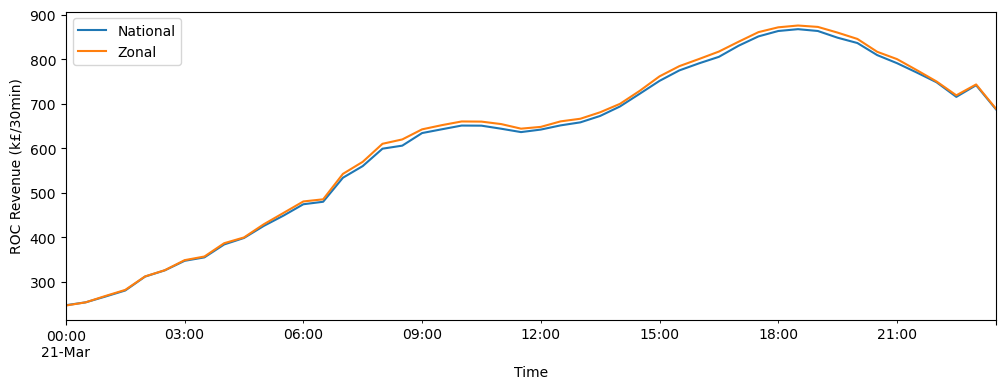

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

roc_rev_nat.plot(ax=ax, label='National')
roc_rev_zon.plot(ax=ax, label='Zonal')

ax.set_ylabel('ROC Revenue (k£/30min)')
ax.set_xlabel('Time')

ax.legend()
plt.show()

In [35]:
color_dict['roc'] = color_dict['roc_payments']
color_dict['cfd'] = color_dict['cfd_payments']
color_dict['ftr'] = color_dict['congestion_rent']
color_dict

{'wholesale': '#F78C6B',
 'wholesale selling': '#F78C6B',
 'wholesale buying': '#c3763c',
 'roc_payments': '#EF476F',
 'cfd_payments': '#06D6A0',
 'congestion_rent': '#FFD166',
 'offer_cost': '#073B4C',
 'bid_cost': '#118AB2',
 'roc': '#EF476F',
 'cfd': '#06D6A0',
 'ftr': '#FFD166'}

In [36]:
from tqdm import tqdm
# total_cost = sc.loc[~sc.index.get_level_values(1).isin(['balancing_volume', 'congestion_rent'])].sum()
# gamma = total_cost['zonal'] / total_cost['national']

total_wind_revenue_national = 0
total_wind_revenue_zon = 0

for bus in tqdm(sorted_buses):
    bus_lat = nat_bal.buses.loc[bus, 'y']
    for i, gen in enumerate(bus_generators[bus]):

        rev_nat = get_unit_revenues(gen, nat_who, nat_bal).mul(1e-3).sum(axis=1)
        rev_zon = get_unit_revenues(gen, zon_who, zon_bal).mul(1e-3).sum(axis=1)

        # import sys
        # sys.exit()

        total_wind_revenue_national += rev_nat.sum()
        total_wind_revenue_zon += rev_zon.sum()

gamma = total_wind_revenue_zon / total_wind_revenue_national
print(gamma)

100%|██████████| 42/42 [00:08<00:00,  4.81it/s]

0.8568877396061446


In [37]:
from plotting_constants import policy_colors

national_color = policy_colors['national']
no_ftr_zonal_color = policy_colors['no_ftr_zonal'] # policy 1 in the paper
zonal_color = policy_colors['zonal'] # policy 2 in the paper
zonal_with_policy_color = policy_colors['zonal_with_policy'] # policy 3 in the paper

In [38]:
def get_handles():
# Create a legend with nice names and consistent styling
    import matplotlib.patches as mpatches

    # Define nice display names for the legend
    nice_names = {
        'wholesale': 'Wholesale Revenue',
        'wholesale selling': 'Wholesale Selling',
        'roc_payments': 'ROC Payments',
        'cfd_payments': 'CFD Payments',
        'congestion_rent': 'Congestion Rent',
        'offer_cost': 'Offer Cost',
        'bid_cost': 'Bid Cost',
        'transmission_congestion_credits': 'Transmission Congestion Credits'
    }

    # Remove redundant entries (keep only unique colors with preferred labels)
    unique_entries = {
        'wholesale': '#F78C6B',
        'roc_payments': '#EF476F',
        'cfd_payments': '#06D6A0',
        'congestion_rent': '#FFD166',
        'offer_cost': '#073B4C',
        'bid_cost': '#118AB2'
    }

    # Create patches for the legend
    legend_handles = []
    for key, color in unique_entries.items():
        patch = mpatches.Patch(
            facecolor=color, 
            alpha=0.6,
            edgecolor=color,
            linewidth=1.5,
            label=nice_names.get(key, key)
        )
        legend_handles.append(patch)


    from matplotlib.lines import Line2D

    for _ in range(3):
        legend_handles.append(Line2D([0], [0], color='w', label=''))

    for label, color in zip(
        ['National Market Revenue', 
        # 'No FTR Zonal Market Revenue'
        'Policy 1 (Simple)'
        ],
        [national_color, no_ftr_zonal_color]
        ):
        legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))
    
    legend_handles.append(Line2D([0], [0], color='w', lw=2, label=''))

    for label, color, ls in zip(
        # ['Simple FTR Zonal Market Revenue', 'Equitable FTR Zonal Market Revenue'],
        ['Policy 2 (Production-Based FTRs)', 'Policy 3 (Grandfathered Merit Order)'],
        [zonal_color, zonal_with_policy_color],
        ['--', '-']
        ):
        legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label, linestyle=ls))
    
    return legend_handles


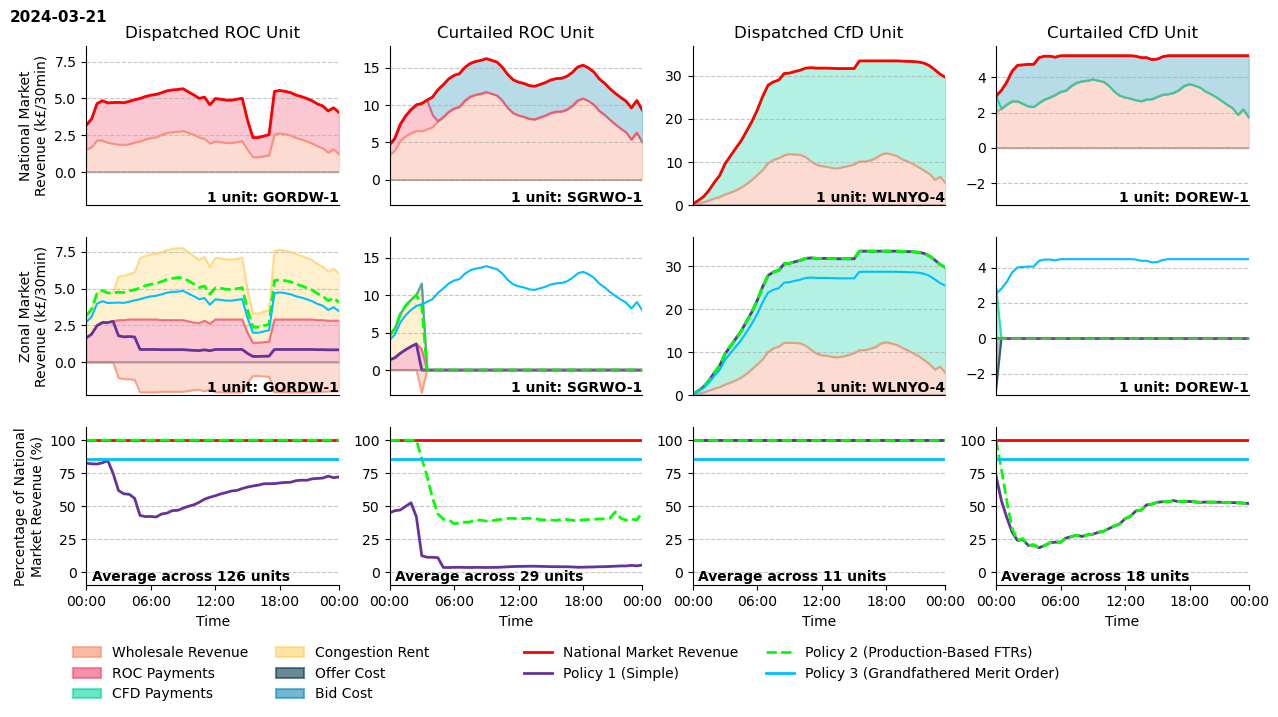

In [41]:

fig, axs = plt.subplots(3, 4, figsize=(15, 7))

for unit, ax_col in zip([
        dispatched_roc_unit,
        curtailed_roc_unit,
        dispatched_cfd_unit,
        curtailed_cfd_unit
    ],
    axs.T):

    nat_rev = get_unit_revenues(unit, nat_who, nat_bal).mul(1e-3)
    zon_rev = get_unit_revenues(unit, zon_who, zon_bal).mul(1e-3)

    global_y_min = min(nat_rev.clip(upper=0).sum(axis=1).min(), zon_rev.clip(upper=0).sum(axis=1).min())
    global_y_max = max(nat_rev.clip(lower=0).sum(axis=1).max(), zon_rev.clip(lower=0).sum(axis=1).max())
    global_y_range = [global_y_min * 1.1, global_y_max * 1.1]


    for j, (ax, rev) in enumerate(zip(ax_col, [nat_rev, zon_rev])):
        
        if j == 1:
            ls = '--'
        else:
            ls = '-'

        ax.set_ylim(global_y_range)

        columns_to_plot = rev.columns[:6]
        base = global_y_min

        pos_cols = [col for col in columns_to_plot if (rev[col] >= 0).any()]
        neg_cols = [col for col in columns_to_plot if (rev[col] < 0).any()]

        pos_stack = pd.DataFrame(0, index=rev.index, columns=pos_cols)
        for col in pos_cols:
            pos_stack[col] = rev[col].clip(lower=0)  # Only keep positive values

        # Create cumulative sums for stacking
        pos_cumsum = pos_stack.cumsum(axis=1)

        # Plot each positive column as stacked area
        for i, col in enumerate(pos_cols):

            if rev[col].clip(lower=0).sum() == 0:
                continue

            # Calculate bottom of current stack
            bottom = 0 if i == 0 else pos_cumsum[pos_cols[i-1]]
            top = pos_cumsum[col]

            ax.fill_between(
                range(0, 48),
                bottom,
                top,
                alpha=0.3,
                label=col,
                color=color_dict[col]
            )
            ax.plot(
                range(0, 48),
                top,
                alpha=0.7,
                color=color_dict[col]
            )

        # Plot negative values stacked on each other
        neg_stack = pd.DataFrame(0, index=rev.index, columns=neg_cols)
        for col in neg_cols:
            neg_stack[col] = rev[col].clip(upper=0)  # Only keep negative values

        # Create cumulative sums for stacking
        neg_cumsum = neg_stack.cumsum(axis=1)

        # Plot each negative column as stacked area
        for i, col in enumerate(neg_cols):

            if rev[col].clip(upper=0).sum() == 0:
                continue

            # Calculate bottom of current stack
            bottom = 0 if i == 0 else neg_cumsum[neg_cols[i-1]]
            top = neg_cumsum[col]

            ax.fill_between(
                range(0, 48),
                bottom,
                top,
                alpha=0.3,
                label=col if col not in pos_cols else f"{col} (neg)",
                color=color_dict[col]
            )
            ax.plot(
                range(0, 48),
                top,
                alpha=0.7,
                color=color_dict[col]
            )
        # Plot total line

        if j == 0:
            total_color = national_color
        else:
            total_color = zonal_color
        
        # print(rev.head())
        if j == 1:
            ax.plot(range(0, 48), rev[
                ['wholesale', 'cfd', 'roc', 'offer_cost', 'bid_cost']].sum(axis=1),
                color=no_ftr_zonal_color, linewidth=2)

        ax.plot(range(0, 48), rev.sum(axis=1), color=total_color, linewidth=2, label='Total', linestyle=ls)

        ax.set_xlim(0, 47)

        # Add horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

    for ax in ax_col[:2]:
        ylim = ax.get_ylim()[0]  # Get the lower y limit
        ax.text(
            47, ylim, f'1 unit: {unit}',
            ha='right',
            va='bottom',
            fontsize=10,
            weight='bold'
        )

    ax_col[1].plot(range(0, 48), nat_rev.sum(axis=1) * gamma, color=zonal_with_policy_color)
    # ax_col[1].fill_between(range(0, 48), 0, nat_rev['total'] * gamma, color=zonal_with_policy_color, alpha=0.1)


'''
max_index = nat_rev['total'].idxmax()
text = f'{100 * gamma:.2f}% of national revenue'
axs[1,2].text(
    nat_rev.index[len(nat_rev)//2],
    (nat_rev['total'] * gamma).loc[max_index],
    text,
    color='magenta',
    fontsize=10,
    ha='center',
    va='bottom',
    weight='bold'
    )
'''

for group, ax in zip([
    dispatched_roc_units, curtailed_roc_units, dispatched_cfd_units, curtailed_cfd_units
], axs[2]):

    total_national = pd.Series(0, index=nat_who.snapshots)
    total_zonal = pd.Series(0, index=zon_who.snapshots)
    total_no_ftr_zon = pd.Series(0, index=zon_who.snapshots)
    total_zonal_with_policy = pd.Series(0, index=zon_who.snapshots)

    for unit in group:
        nat_rev = get_unit_revenues(unit, nat_who, nat_bal).mul(1e-3)
        zon_rev = get_unit_revenues(unit, zon_who, zon_bal).mul(1e-3)

        zon_with_policy = nat_rev.mul(gamma).sum(axis=1)

        nat_perc = (nat_rev.sum(axis=1) / nat_rev.sum(axis=1)).replace(np.nan, 0)
        zon_perc = (zon_rev.sum(axis=1) / nat_rev.sum(axis=1)).replace(np.nan, 0)
        no_ftr_zon_perc = (

            zon_rev[['wholesale', 'cfd', 'roc', 'offer_cost', 'bid_cost']].sum(axis=1) /
            nat_rev.sum(axis=1)).replace(np.nan, 0)

        zon_with_policy_perc = (zon_rev.sum(axis=1) * gamma / nat_rev.sum(axis=1)).replace(np.nan, 0)

        total_national = total_national.add(nat_rev.sum(axis=1))
        total_zonal = total_zonal.add(zon_rev.sum(axis=1))

        total_no_ftr_zon = total_no_ftr_zon.add(zon_rev[['wholesale', 'cfd', 'roc', 'offer_cost', 'bid_cost']].sum(axis=1))
        total_zonal_with_policy = total_zonal_with_policy.add(zon_with_policy)

    total_zonal /= total_national
    total_zonal_with_policy /= total_national
    total_no_ftr_zon /= total_national
    total_national /= total_national

    ax.plot(range(0, 48), total_national * 100, color=national_color, lw=2)
    # ax.plot(range(0, 48), total_national * 100, color='k', lw=0.5)
    ax.plot(range(0, 48), total_no_ftr_zon * 100, color=no_ftr_zonal_color, lw=2, linestyle='-')
    ax.plot(range(0, 48), total_zonal.clip(upper=1) * 100, color=zonal_color, lw=2, linestyle='--')
    # ax.plot(range(0, 48), total_zonal * 100, color='k', lw=0.5)
    ax.plot(range(0, 48), total_zonal_with_policy * 100, color=zonal_with_policy_color, lw=2)
    # ax.plot(range(0, 48), total_zonal_with_policy * 100, color='k', lw=0.5)

    ax.set_ylim(-10, 110)


for ax in axs.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

for ax, title in zip(axs[0], ['Dispatched ROC Unit', 'Curtailed ROC Unit', 'Dispatched CfD Unit', 'Curtailed CfD Unit']):
    ax.set_title(title)

for ax, prefix in zip(axs[:2,0], ['National Market', 'Zonal Market', 'Zonal Market']):
    ax.set_ylabel(f'{prefix}\nRevenue (k£/30min)')


for ax in axs[:2,:].flatten():
    ax.set_xticks([])

axs[0,0].text(
    4,
    11,
    f'{day}',
    ha='right',
    va='top',
    fontsize=11,
    weight='bold'
)

# Set x-tick labels for the bottom row of axes to show hours
for ax in axs[2]:
    # Create 5 evenly spaced time points
    tick_positions = [0, 12, 24, 36, 47]
    tick_labels = ['00:00', '06:00', '12:00', '18:00', '00:00']
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlim(0, 47)
    ax.set_xlabel('Time')


axs[2,0].set_ylabel('Percentage of National\nMarket Revenue (%)')

for ax, group in zip(axs[2], [dispatched_roc_units, curtailed_roc_units, dispatched_cfd_units, curtailed_cfd_units]):
    ax.text(
        1, -9, f'Average across {len(group)} units',
        ha='left',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

legend_handles = get_handles()

axs[2,1].legend(
    handles=legend_handles,
    bbox_to_anchor=(2.7, -0.3),
    ncol=5,
    frameon=False
    )

plt.savefig('revenue_stabilisation.pdf', bbox_inches='tight')
plt.show()